In [2]:
pip install lasio

In [3]:
pip install welly

     |████████████████████████████████| 51kB 1.6MB/s 
     |████████████████████████████████| 81kB 3.6MB/s 
  Created wheel for welly: filename=welly-0.4.7-cp36-none-any.whl size=51555 sha256=74d61f8b198e3f06f2b79274d72f08b635c5ebb4e136c4e7dbfed580f7842cdd
  Stored in directory: /root/.cache/pip/wheels/1f/a6/e3/8543907612eab77a66ec2193df115c2580fd863bea3c092a44
  Created wheel for striplog: filename=striplog-0.8.5-cp36-none-any.whl size=80744 sha256=21bd17d5954c917cafbcf5463723a07254fa06c08b7da1fb663c105e9eef5abf
  Stored in directory: /root/.cache/pip/wheels/a6/09/bd/87093a5be4a55cc7cacf9668e2dc0f3c905a1621b120af4820
Successfully built welly striplog


In [4]:
import welly
from welly import Well
import pandas as pd
import lasio
import numpy as np

In [5]:
from google.colab import files 
uploaded = files.upload()

Saving 15_9-F-1A.LAS to 15_9-F-1A.LAS


In [7]:
w = Well.from_las('15_9-F-1A.LAS')
# w.header                      # runing with welly lib we are not able to see las header data
w_las= lasio.read(r'15_9-F-1A.LAS') # lasio lib will help
w_las.header

/usr/local/lib/python3.6/dist-packages/welly/well.py:173: FutureWarning: From v0.5 the default will be 'original', keeping whatever is used in the LAS file. If you want to force conversion to metres, change your code to use `index='m'`.
  warnings.warn(m, FutureWarning)


{'Curves': [CurveItem(mnemonic="DEPTH", unit="M", value="00 001 00 00", descr="0  Depth", original_mnemonic="DEPTH", data.shape=(35361,)),
  CurveItem(mnemonic="ABDCQF01", unit="g/cm3", value="00 000 00 00:   1  ABDCQF01:COMPOSITE:rC:0001", descr="v1", original_mnemonic="ABDCQF01", data.shape=(35361,)),
  CurveItem(mnemonic="ABDCQF02", unit="g/cm3", value="00 000 00 00:   2  ABDCQF02:COMPOSITE:rC:0001", descr="v1", original_mnemonic="ABDCQF02", data.shape=(35361,)),
  CurveItem(mnemonic="ABDCQF03", unit="g/cm3", value="00 000 00 00:   3  ABDCQF03:COMPOSITE:rC:0001", descr="v1", original_mnemonic="ABDCQF03", data.shape=(35361,)),
  CurveItem(mnemonic="ABDCQF04", unit="g/cm3", value="00 000 00 00:   4  ABDCQF04:COMPOSITE:rC:0001", descr="v1", original_mnemonic="ABDCQF04", data.shape=(35361,)),
  CurveItem(mnemonic="BS", unit="inches", value="00 000 00 00:   5  BS:COMPOSITE:rC:NONE", descr="v1", original_mnemonic="BS", data.shape=(35361,)),
  CurveItem(mnemonic="CALI", unit="inches", valu

In [8]:
w.data['DT'] = w.data['DT'] / 0.3048   #unit convert to µs/m
w.data['RHOB'] = w.data['RHOB'] * 1000  #unit convert to kg/m3

In [9]:
#Despiking
#Sonic Despiking
dt = w.data['DT']
w.data['DT_DS'] = dt.despike(window_length=50, z=2)

#Density Despiking
den = w.data['RHOB']
w.data['RHOB_DS'] = den.despike(window_length=50, z=2)


In [10]:
#Smoothing 
#Sonic Smoothing
dt_ds = w.data['DT_DS']
w.data['DT_DS_SM'] = dt_ds.smooth(window_length=10, samples=False)

#Density Smoothing
den_ds = w.data['RHOB_DS']
w.data['RHOB_DS_SM'] = den_ds.smooth(window_length=10, samples=False)

In [ ]:
##2- Time-Depth relationship

In [16]:
log_start = 1517               # Depth of logging starts(m) from header
kb = 15                        # Kelly Bushing elevation(m) from header

In [20]:
gap_int = log_start - kb
repl_vel = 2632                # this is from VSP data knowledge (m/s)
log_start_time = 2.0 * gap_int / repl_vel        # 2 for twt

In [21]:
#first replace NaN values with zero
dt_iterval = np.nan_to_num(dt) * 0.1524 / 1e6
t_cum =  np.cumsum(dt_iterval) * 2
w.data['TWT'] = t_cum + log_start_time

In [19]:
df = w.df()

In [ ]:
###3- Acoustic Impedance

In [22]:
# Sonic velocity calculate
df['Vsonic'] = 1e6/df.DT_DS_SM                    #(unit: m/s)

In [23]:
# AI calculate
df['AI'] = df['Vsonic'] * df['RHOB_DS_SM']        #(unit: kg/m2.s)

In [ ]:
##4- Reflection Coefficient

In [24]:
Imp = df['AI'].values
Rc=[]
for i in range(len(Imp)-1):
    Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

# to adjust vector size copy the last element to the tail
Rc.append(Rc[-1])

In [25]:
# Let's add Rc into dataframe as new column
df['Rc'] = pd.Series(Rc, index=df.index)

In [ ]:
###5- Resampling to the time domain and Rc calculation

In [26]:
dt = 0.001   #sampleing interval
t_max = 3.0   # max time to create time vector
t = np.arange(0, t_max, dt)
AI_tdom = np.interp(x=t, xp = df.TWT, fp = df.AI)    #resampling

In [27]:
# again Rc calulation but in reampled time domain
Rc_tdom = []
for i in range(len(AI_tdom)-1):
    Rc_tdom.append((AI_tdom[i+1]-AI_tdom[i])/(AI_tdom[i]+AI_tdom[i+1]))
# to adjust vector size copy the last element to the tail
Rc_tdom.append(Rc_tdom[-1])

In [ ]:
##6- Wavelet & Convolution

In [28]:
# define function of ricker wavelet
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y

In [29]:
##Convolution
f=20            #wavelet frequency
length=0.512    #Wavelet vector length
dt=dt           # Sampling prefer to use smiliar to resampled AI
t0, w = ricker (f, length, dt) # ricker wavelet 
synthetic = np.convolve(w, Rc_tdom, mode='same')

In [30]:
from google.colab import files 
uploaded = files.upload()


Saving 159F1formation top.xlsx to 159F1formation top.xlsx


In [31]:
df_top = pd.read_excel('159F1formation top.xlsx') # read from csv file into dataframe


In [34]:
df_top.head()

,TOP,MD
0,Hordaland GP,1355
1,Hordaland GP(Balder FM),2394
2,Rogaland GP(ListaFM),2527
3,Rogaland GP(Ty FM),2631
4,Shetland GP(Tor FM),2788


In [35]:
tops_dept = dict(df_top.values.tolist())  # convert to dictionary

In [36]:
def nearest_value(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [37]:
TWT=df.TWT.values
tops_twt={}
for key, val in tops_dept.items():
    tops_twt[key]=TWT[nearest_value(df.index, val)]

In [39]:
import matplotlib.pyplot as plt

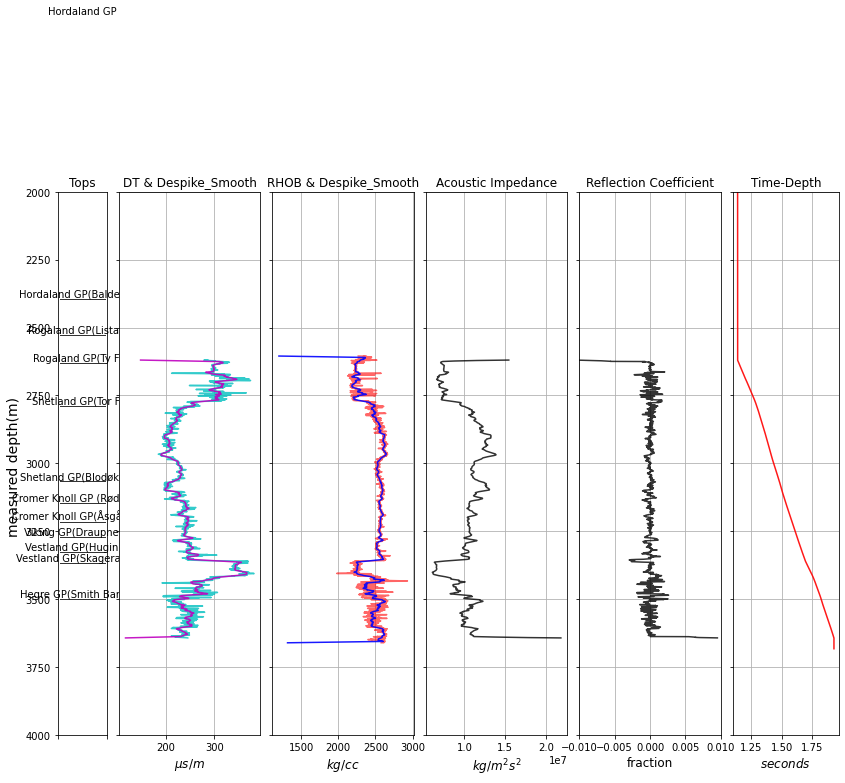

In [43]:
fig, axs = plt.subplots(1, 6, sharey=True, figsize = (14,10), gridspec_kw={'width_ratios': [0.7,2,2,2,2,1.5]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Tops', style = 'normal')
axs[0].set_ylabel('measured depth(m) ', fontsize = '14' )
axs[0].set_xticklabels('')
for Top in tops_dept.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, MD in tops_dept.items():
    axs[0].text( x = 0.5,  y = float(MD), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( df.DT, df.index,'c', alpha=0.8)
axs[1].plot( df.DT_DS_SM, df.index,'m', alpha=0.9)
axs[1].set_title('DT & Despike_Smooth', style = 'normal')
axs[1].set_xlabel( r'$\mu s/m $', fontsize = '12')
axs[1].set_ylim(1000, 5000)
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( df.RHOB, df.index,'r', alpha=0.6)
axs[2].plot( df.RHOB_DS_SM, df.index,'b', alpha=0.9)
axs[2].set_title('RHOB & Despike_Smooth', style = 'normal')
axs[2].set_xlabel('$kg/cc$', fontsize = '12')
axs[2].set_ylim(1000, 5000)
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------  
axs[3].plot( df.AI, df.index,'k', alpha=0.8)
axs[3].set_title('Acoustic Impedance', style = 'normal')
axs[3].set_xlabel( r'$kg/m^2s^2$', fontsize = '12')
axs[3].set_ylim(1000, 5000)
axs[3].invert_yaxis()
axs[3].grid()
# -----------------------------------------------------------------------------------track5-----------
axs[4].plot( df.Rc, df.index,'k', alpha=0.8)
axs[4].set_title('Reflection Coefficient', style = 'normal')
axs[4].set_xlabel('fraction' , fontsize = '12')
axs[4].set_ylim(1000, 5000)
axs[4].set_xlim(-0.01, 0.01)
axs[4].invert_yaxis()
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
axs[5].plot( df.TWT, df.index,'r', alpha=0.9)
axs[5].set_title('Time-Depth', style = 'normal')
axs[5].set_xlabel( '$seconds$', fontsize = '12')
axs[5].set_ylim(2000, 4000)
axs[5].invert_yaxis()
# axs[5].set_yticklabels('')
axs[5].grid()
plt.savefig('Fig1.png', dpi=300)

In [44]:
from google.colab import files 
uploaded = files.upload()


Saving around_well_seismic.csv to around_well_seismic.csv


In [50]:
df_offset_seis= pd.read_csv('around_well_seismic.csv')

In [51]:
df_offset_seis

,time,cdp409,cdp410,cdp412,cdp413
0,0.000,0,0,0,0
1,0.004,0,0,0,0
2,0.008,0,0,0,0
3,0.012,0,0,0,0
4,0.016,0,0,0,0
...,...,...,...,...,...
1371,5.484,2520,845,3835,3772
1372,5.488,13512,15714,18454,18894
1373,5.492,19757,21341,22921,23256
1374,5.496,20333,20500,20598,20658


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in greater


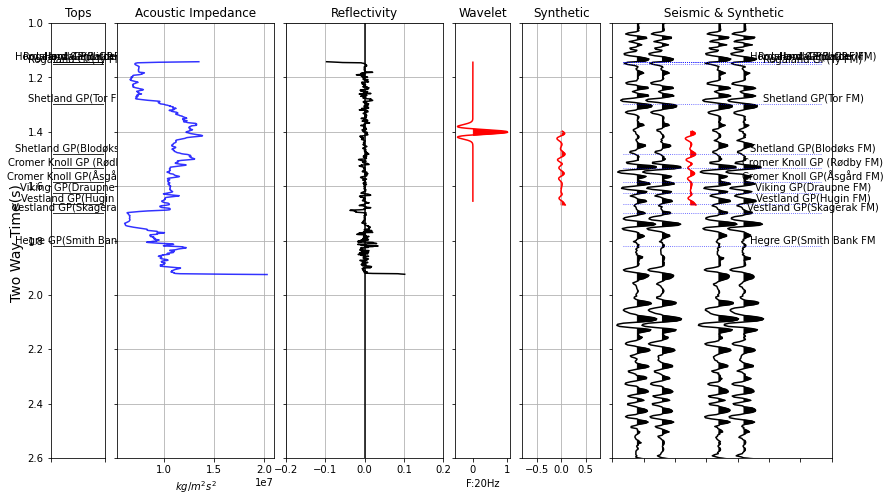

In [52]:
fig, axs = plt.subplots(1, 6, sharey=False, figsize = (14,8), gridspec_kw={'width_ratios': [0.7,2,2,0.7,1,2.8]})
fig.subplots_adjust(wspace=0.1)
# -----------------------------------------------------------------------------------track1------------
axs[0].set_title('Tops', style = 'normal')
axs[0].set_ylabel('Two Way Time(s) ', fontsize = '14' )
axs[0].set_xticklabels('')
axs[0].set_ylim(1 , 2.6)
axs[0].invert_yaxis()

for Top in tops_twt.values() :
    axs[0].axhline( y = float(Top), color = 'k', lw = 1,   
                            alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[0].text( x = 0.5,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')
# -----------------------------------------------------------------------------------track2------------
axs[1].plot( AI_tdom, t,'b', alpha=0.8)
axs[1].set_title('Acoustic Impedance', style = 'normal')
axs[1].set_xlabel( r'$kg/m^2s^2$', fontsize = '10')
axs[1].set_ylim(1 , 2.6)
axs[1].set_yticklabels('')
axs[1].invert_yaxis()
axs[1].grid()
# -----------------------------------------------------------------------------------track3------------
axs[2].plot( Rc_tdom, t,'k')
axs[2].plot([0, 0], [t.min(), t.max()], '-', c='k')
axs[2].set_title('Reflectivity', style = 'normal')
axs[2].set_ylim(1 , 2.6)
axs[2].set_xlim(-0.2 , 0.2)
axs[2].set_yticklabels('')
axs[2].invert_yaxis()
axs[2].grid()
# -----------------------------------------------------------------------------------track4------------   
axs[3].plot( w, t0+1.4,'r', alpha=0.99)
axs[3].fill_betweenx(t0+1.4 , w,  0,  w > 0.0,  color='r')
axs[3].set_title('Wavelet', style = 'normal')
axs[3].set_xlabel('F:'+ str(f)+'Hz' , fontsize = '10')
axs[3].set_yticklabels('')
axs[3].set_ylim(1 , 2.6)
axs[3].invert_yaxis()
# -----------------------------------------------------------------------------------track5------------
axs[4].plot( synthetic, t ,'r')
axs[4].fill_betweenx(t, synthetic,  0,  synthetic > 0,  color='r')
axs[4].set_title('Synthetic', style = 'normal')
axs[4].set_ylim(1 , 2.6)
axs[4].set_xlim(-0.8 , 0.8)
axs[4].invert_yaxis()
axs[4].set_yticklabels('')
axs[4].grid()
# -----------------------------------------------------------------------------------track6------------
offsets=[0.4, 0.8 , 1.25, 1.7, 2.1]

x1= (df_offset_seis.cdp409.values/1e5) + offsets[0]
x2= (df_offset_seis.cdp410.values/1e5) + offsets[1]
x3= (df_offset_seis.cdp412.values/1e5) + offsets[3]
x4= (df_offset_seis.cdp413.values/1e5) + offsets[4]
t_sei=df_offset_seis.time

axs[5].plot( x1, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[0] , x1, where=(x1>offsets[0]),color='k')
axs[5].plot( x2, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[1] , x2, where=(x2>offsets[1]),color='k')
axs[5].plot( synthetic+offsets[2], t ,'r')
axs[5].fill_betweenx(t, offsets[2] , (synthetic+offsets[2]),
                     where=((synthetic+offsets[2])>offsets[2]),color='r')
axs[5].plot( x3, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[3] , x3, where=(x3>offsets[3]),color='k')
axs[5].plot( x4, t_sei ,'k')
axs[5].fill_betweenx(t_sei, offsets[4] , x4, where=(x4>offsets[4]),color='k')

axs[5].set_title(' Seismic & Synthetic', style = 'normal')
axs[5].set_yticklabels('')
axs[5].set_xticklabels('')
axs[5].set_ylim(1 , 2.6)
axs[5].set_xlim(0 , 03.5)
axs[5].invert_yaxis()
for Top in tops_twt.values() :
    axs[5].axhline( y = float(Top), color = 'b', lw = 0.8, ls = ':', 
                   alpha = 0.8, xmin = 0.05, xmax = 0.95 )
for Top, S in tops_twt.items():
    axs[5].text( x = 3.2,  y = float(S), s = Top,fontsize = '10', 
                horizontalalignment = 'center',verticalalignment = 'bottom')    

plt.savefig('Fig2.png', dpi=600)